## Objective
Run prop algorithm with DL templates

As I mentioned, I still think that the sequences algorithm is helpful for detecting units since in this case the results are averaged over many spikes. However, the sequence during a single spike is too variable to be a good measure for its detection. Instead, we can use the model output directly. We would do this as follows:

Before real time analysis:
1. For the first part of the recording, we use the DL output to detect sequences according to the latest version of the algorithm.
2. For each detected sequence, we take the DL model prediction output per channel and average this over all the spike detections in the first part of the recording that led to the unit detection.
3. From the averaged model prediction output, we take a certain amount of frames before and after the waveform trough of the channel with on average the highest trough amplitude. Let's make the number of frames before and after the trough adjustable parameters that we can tune later. For now, maybe we can use 0.5ms before and after. 
4. We concatenate all the averaged model prediction outputs per channel into a long array. This gives us a long array for each detected unit in 1.

During real time analysis:
5. Every 0.5ms (or more if we can do so computationally), we take the model output from all channels and concatenate them into a long array, similar to what we did in step 4.
6. We multiply this array with each of the arrays in step 4 (element wise multiplication) and sum the results. This gives us a single value for each unit.
7. If the results for one or multiple arrays from 4 pass a threshold, we choose the array from 4 that leads to the highest score and assign a spike to this unit. Let's explore what a good threshold value would be and tune this later.
8. The spike time is the time of the through in the channel with the highest amplitude identified in step 3.

## General setup

In [1]:
%load_ext autoreload

In [31]:
%autoreload 2

import numpy as np
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# Load recording and model's detected spikes

from spikeinterface import load_extractor
from src.recording import Recording

RECORDING = load_extractor("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/spike_band.si")
RECORDING = Recording(RECORDING)

CHANS_RMS = np.load("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/chans_rms.npy")

MODEL_ROOT = Path("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/windows_200_120")
PROP_ROOT = MODEL_ROOT / "prop_signal"
# PROP_ROOT.mkdir(exist_ok=False)

MODEL_TIMES = np.load(MODEL_ROOT / "spike_times.npy", allow_pickle=True)
MODEL_TIMES = [np.asarray(mt) for mt in MODEL_TIMES]

MODEL_OUTPUTS = np.load(MODEL_ROOT / "outputs.npy", mmap_mode="r")

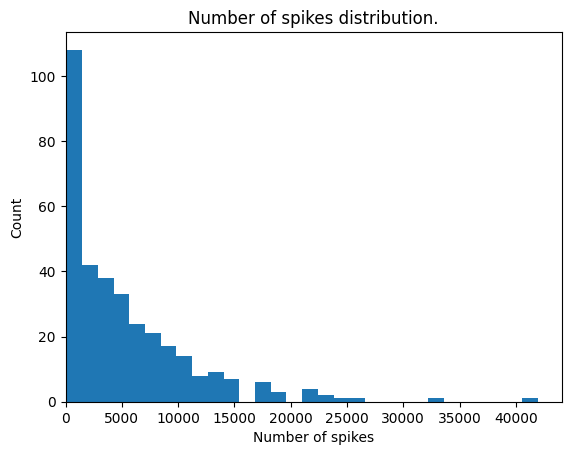

Mean: 5286.78
STD: 5777.55


In [4]:
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison

kilosort = Kilosort("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/probe_773592320/spikesort_matlab4", "first", RECORDING)
kilosort.plot_nums_spikes(bins=30)
kilosort_spikes = np.unique(np.concatenate(kilosort.get_spike_times()))

## Create units

### Detect sequences

In [5]:
# Create candidate cohorts
from src.prop_signal import v1_4 as ps_alg

MIN_PROP_SPIKES = 1 * 20 * 60  # min_firing_rate * mins * 60_seconds_per_min

# candidate_cohorts = ps_alg.scan_reference_electrode(MODEL_TIMES, sampling_freq=30, min_prop_spikes=MIN_PROP_SPIKES, min_ccg_ratio=0.5,
#                                                     ccg_before=1.5, ccg_after=1.5, ccg_small_window=0.5, ccg_big_window=2)

# import pickle
# with open(PROP_ROOT / "candidate_cohorts.pkl", "wb") as file:
#         pickle.dump(candidate_cohorts, file)
        
import pickle
with open(PROP_ROOT / "candidate_cohorts.pkl", "rb") as file:
    candidate_cohorts = pickle.load(file)

# import pickle
# with open("/data/MEAprojects/buzsaki/SiegleJ/AllenInstitute_744912849/session_766640955/dl_models/230710/c/230710_172227_706810/log/prop_signal/candidate_cohorts.pkl", "rb") as file:
#     candidate_cohorts = pickle.load(file)


In [6]:
# Form propagations
electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                    min_cocs_n=0, min_cocs_p=30,  # 40  
                                                    min_cocs_2_p=50)
propagations = ps_alg.get_propagations(electrode_cohorts, 0.001)
len(propagations)

124

### Build model output templates

In [ ]:
# Find which spike detections contributed to propagation being formed i.e. start electrode + at least one other electrode coactivate 

from tqdm import tqdm

MODEL_AMPS = np.load(
    MODEL_ROOT / "spike_amps.npy",
    allow_pickle=True
)

PROP_AFTER = 0.5  # Coactivations must occur within PROP_AFTER ms
MIN_COACTIVATIONS = 2 # -1  # -1 = all electrodes must have spike, 
ISI_VIOL = 1.5

def get_prop_times_and_amps(prop, min_coactivations):
    """
    For one propagation
    
    ref = crossing of first/anchor electrode in prop
    tar = crossing of another electrode in prop
    """
    
    if min_coactivations == -1:
        min_coactivations = len(prop)

    # min_coactivations = max(2, ceil(len(prop) / 2))

    if len(prop) < min_coactivations:
        return np.array([]), np.array([np.nan for _ in range(len(prop))])
    
    ref_elec = prop.ID[0]
    ref_cross_times = MODEL_TIMES[ref_elec]
    ref_cross_amps = MODEL_AMPS[ref_elec]
    
    propagating_data = {}  # (ref_time, ref_amp) : [(tar1_elec, tar1_amp), (tar2_elec, tar2_amp), ...]
    for tar_elec in prop.ID[1:]:
        tar_cross_times = MODEL_TIMES[tar_elec]
        tar_cross_amps = MODEL_AMPS[tar_elec]
        
        for ref_time, ref_amp in zip(ref_cross_times, ref_cross_amps):
            # Find closest target cross
            i_tar = np.searchsorted(tar_cross_times, ref_time, side="left")
            
            # Count as coactivation if within PROP_AFTER
            if i_tar < len(tar_cross_times) and tar_cross_times[i_tar] <= ref_time + PROP_AFTER:
                ref = (ref_time, ref_amp)
                tar = (tar_elec, tar_cross_amps[i_tar])
                if ref not in propagating_data:
                    propagating_data[ref] = [tar]
                else:
                    propagating_data[ref].append(tar)
                    
    keys = list(propagating_data.keys())
    ref_times = [k[0] for k in keys]
    order = np.argsort(ref_times)
        
    propagating_times = []
    propagating_amps = {elec: [] for elec in prop.ID.values}  # elec : amps
    last_ref_time = -np.inf
    for idx in order:
        
        ref_time, ref_amp = keys[idx]
        tars = propagating_data[keys[idx]]
        if len(tars) + 1 < min_coactivations:  # +1 since being in list counts as 2 coactivations
            continue
        
        if ref_time <= last_ref_time + ISI_VIOL:  # ISI violation
            continue
        last_ref_time = ref_time
        
        propagating_times.append(ref_time)
        propagating_amps[ref_elec].append(ref_amp)
        for elec, amp in tars:
            propagating_amps[elec].append(amp)
        
    propagating_amps = np.array([np.mean(amps) for amps in propagating_amps.values()])
    
    return propagating_times, propagating_amps
        

def get_propagating_times_and_amps_all():
    # For all propagations
    propagating_times = []
    propagating_amps = []
    
    for prop in tqdm(propagations):
        prop_times, prop_amps = get_prop_times_and_amps(prop, MIN_COACTIVATIONS)
        propagating_times.append(prop_times)
        propagating_amps.append(prop_amps)
        
    return propagating_times, propagating_amps


propagating_times, propagating_amps = get_propagating_times_and_amps_all()

In [194]:
from src.sorters.prop_signal import PropSignal, PropUnit
prop_signal = PropSignal([propagations, propagating_times], RECORDING)

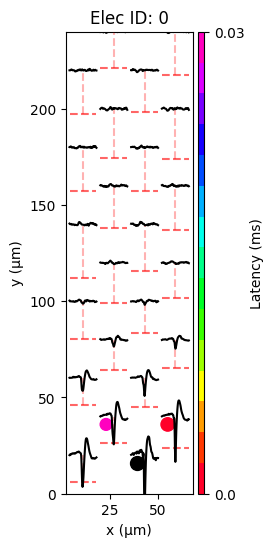

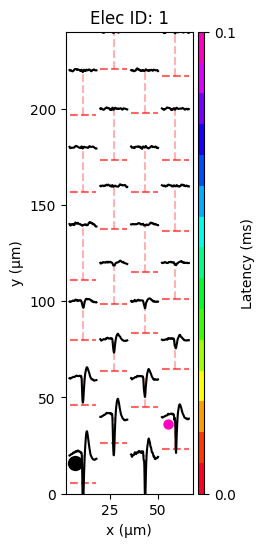

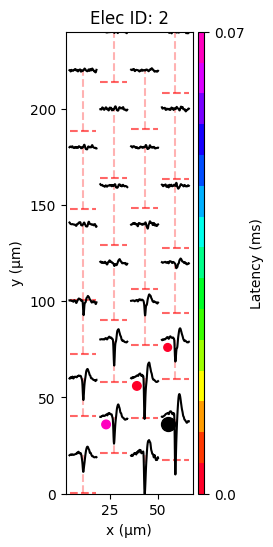

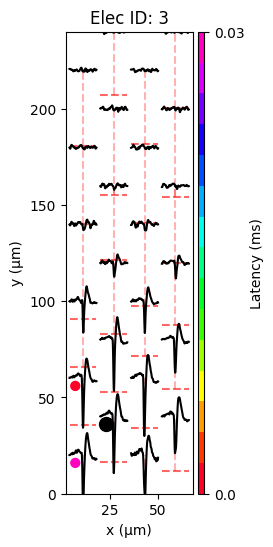

In [97]:
for i in range(4):
    prop_signal[i].plot(chans_rms=CHANS_RMS)

In [20]:
FRONT_BUFFER = 40  # Model's front sample buffer
SAMP_FREQ = 30  # kHz

def time_to_rec_frame(time_ms):
    return round(time_ms * SAMP_FREQ)

def time_to_output_frame(time_ms):
    # Convert time to frame in model outputs.npy
    # time = time_ms * RECORDING.get_sampling_frequency()
    # return int(time) - FRONT_BUFFER
    return round(time_ms * SAMP_FREQ) - FRONT_BUFFER

def output_frame_to_time(frame):
    return (frame + FRONT_BUFFER) / SAMP_FREQ

def output_frame_to_rec_frame(frame):
    return frame + FRONT_BUFFER

def sigmoid(x):
    # return np.where(x>=0,
    #                 1 / (1 + np.exp(x)),
    #                 np.exp(x) / (1+np.exp(x))
    #                 )
    return np.exp(x) / (1+np.exp(x))  # Positive overflow is not an issue because DL does not output large positive values (only large negative)
    

In [ ]:
N_BEFORE = int(0.5 * RECORDING.get_sampling_frequency())
N_AFTER = int(0.5 * RECORDING.get_sampling_frequency())

unit_templates = []
for times in propagating_times[0:1]:
    template = []
    for time in tqdm(times):
        time = time_to_output_frame(time)
        
        output = MODEL_OUTPUTS[:, time-N_BEFORE:time+N_AFTER]
        output = sigmoid(output)
        
        template.append(output)
    template = np.array(template)
    template = np.mean(template, axis=0)
    
    unit_templates.append(template)
    
unit_templates = np.array(unit_templates)
# np.save(PROP_ROOT / "unit_templates.npy", unit_templates)

  0%|          | 0/9789 [00:00<?, ?it/s]

100%|██████████| 9789/9789 [01:29<00:00, 109.30it/s]


In [ ]:
template = unit_templates[0]

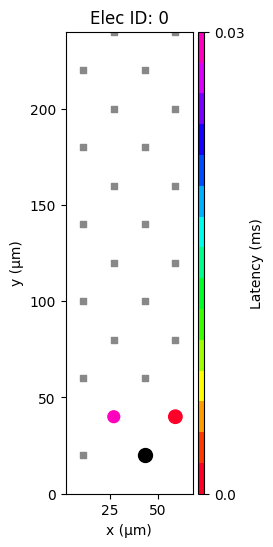

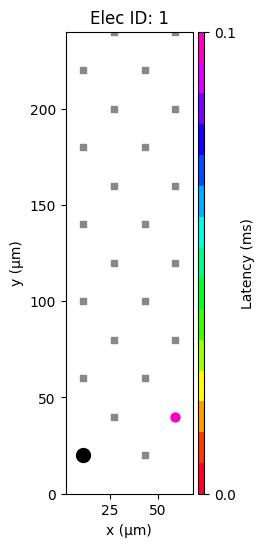

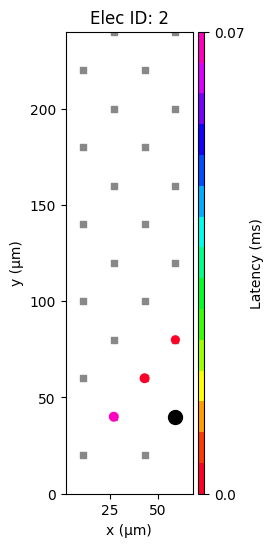

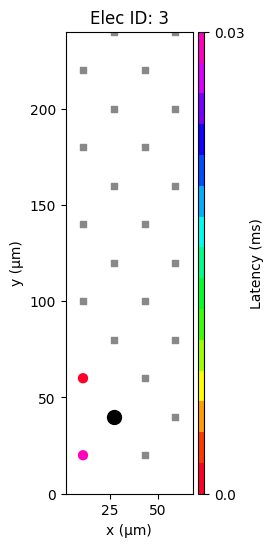

In [ ]:
for i in range(4):
    prop_signal[i].plot()

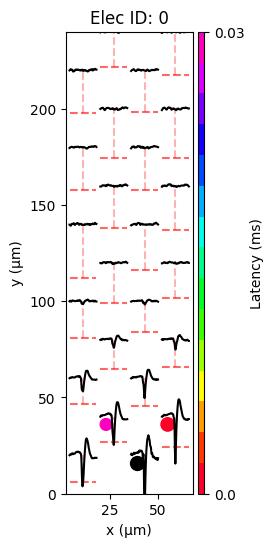

In [ ]:
prop_signal[0].plot(chans_rms=CHANS_RMS)

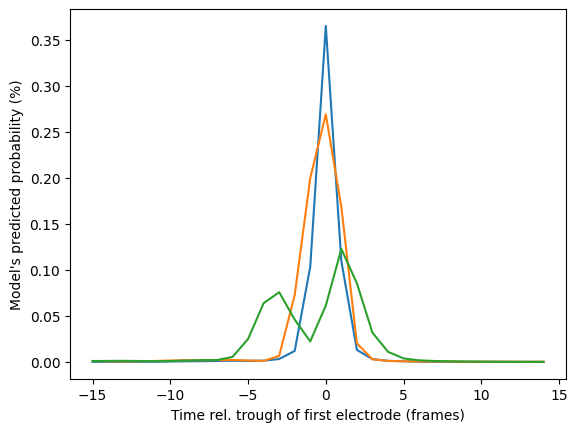

In [ ]:
plot_template(template, chans=[0, 2, 3])

In [ ]:
# unit_templates = np.load(PROP_ROOT / "unit_templates.npy", mmap_mode="r")

#### Plot some templates

In [201]:

import matplotlib.pyplot as plt

# def plot_template(idx, dec=0.00):
#     x_values = np.arange(unit_templates.shape[-1]+1) - unit_templates.shape[-1]//2
#     # x_values = x_values / 30
#     for i, c in enumerate(propagations[idx].ID):
#         plt.plot(x_values, (unit_templates[idx, c, :]*100 - i * dec).tolist() + [0])
#     plt.title(idx)
#     plt.ylabel("Model's predicted probability (%)")
#     plt.xlabel("Time rel. trough of first electrode (frames)")
#     # plt.xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
#     # plt.xlim(-0.5, 0.5)
#     plt.show()

def plot_template(template, chans, dec=0.00):
    x_values = np.arange(unit_templates.shape[-1]) - unit_templates.shape[-1]//2
    # x_values = x_values / 30
    for c in chans:
        plt.plot(x_values, template[c, :])
    plt.ylabel("Model's predicted probability (%)")
    plt.xlabel("Time rel. trough of first electrode (frames)")
    # plt.xticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])
    # plt.xlim(-0.5, 0.5)
    plt.show()
    
def plot_wf(sig, **plot_kwargs):
    # Plot a wf and center it 
    x_values = np.arange(sig.size) - sig.size // 2
    
    plt.plot(x_values, sig, **plot_kwargs)
    
    # plt.xticks(range(-10, 11, 2))
    # plt.xlim(-10, 10)
    plt.xlim(x_values[0], x_values[-1])
    
def plot_frames(x=[-4, -3, -2, -1, 0, 1, 2, 3, 4]):
    # Plot frame lines
    for x_value in x:
        plt.axvline(x_value, color="black", linestyle="dashed", alpha=0.4)

In [ ]:
IDX = 0
CHANS = [0, 2, 3]  # [0, 2, 3, 1]
COLORS = ["C0", "C1", "C2", "C3", "C4"]
N_SPIKES = 100

np.random.seed(101)
##
COLORS = {chan:c for chan, c in zip(CHANS, COLORS)}

all = []
# times = np.random.choice(propagating_times[IDX], N_SPIKES, replace=False)
times = np.random.choice(spike_times, N_SPIKES, replace=False)

for time in tqdm(times):
    output_frame = time_to_output_frame(time)
    outputs = MODEL_OUTPUTS[:, output_frame-10:output_frame+11]
    outputs = sigmoid(outputs)
    
    # score = cos_sim(outputs.flatten(), unit_templates[idx].flatten())
    # plt.title(f"{output_frame}, {score}")
    
    for chan in CHANS:
        # plot_wf(outputs[chan], c=COLORS[chan], alpha=0.3, lw=0.5)
        plot_wf(outputs[chan], c=COLORS[chan], alpha=1, lw=1)
    all.append(outputs)
    
    plot_frames()
    
    plt.show()
    

all = np.array(all)
all = np.mean(all, axis=0)
for chan in CHANS:
    plot_wf(all[chan], c=COLORS[chan], lw=3)

plot_frames()

plt.show()

## Detect spikes

In [8]:
def sigmoid_inv(y):
    return np.log(y/(1-y))
sigmoid_inv(0.05)

-2.9444389791664403

In [18]:
from math import ceil

COACTIVATIONS_N_MIN = 2
COACTIVATIONS_P_MIN = 50
ISI_VIOL = 1.5 * SAMP_FREQ  # frames
MODEL_THRESH = sigmoid_inv(0.1) # -1.5505974124111668 # in logit form (before sigmoid), after sigmoid = 17.5

propagating_times = []
# propagating_amps = []
for prop in tqdm(propagations):
    coactivations_min = max(COACTIVATIONS_N_MIN, ceil(COACTIVATIONS_P_MIN/100 * len(prop)))

    if len(prop) < coactivations_min:
        propagating_times.append(np.array([]))
        continue
    
    spike_times = []
    # spike_amps = np.zeros(len(prop), dtype=float)
    last_spike = -np.inf  # Prevent ISI violations
    for frame in np.flatnonzero(MODEL_OUTPUTS[prop.ID[0], :] >= MODEL_THRESH):
        if frame - last_spike <= ISI_VIOL:
            continue
        
        coactivations = 1  # coac = coactivation
        for chan, latency in zip(prop.ID[1:], prop.latency[1:]):
            coac_frame = frame + round(latency * SAMP_FREQ)
            if MODEL_OUTPUTS[chan, coac_frame] >= MODEL_THRESH:
                coactivations += 1
                
            if coactivations >= coactivations_min:
                spike_times.append(output_frame_to_time(frame))
                # rec_frame = output_frame_to_rec_frame(frame)
                # spike_amps += RECORDING.get_traces_filt(rec_frame, rec_frame+1, prop.ID.values).flatten()
                last_frame = frame
                break
            
    propagating_times.append(spike_times)
    # propagating_amps.append(spike_amps / len(spike_times))

    # Comparison with kilosort units        
    # print(f"Prop: {prop.ID[0]}", len(spike_times))
    # for ks_idx in range(4):
    #     ks = kilosort[ks_idx].spike_train
    #     print(f"Kilosort {ks_idx} idx, {kilosort[ks_idx].chan} chan: ", len(ks))
    #     matches = Comparison.count_matching_events(spike_times, ks, delta=2)
    #     print("Matches: ", matches)
    #     print(f"/Prop: {matches/len(spike_times):.3f}")
    #     print(f"/Kilosort: {matches/len(ks):.3f}")
    #     print()
    # print("\n" + "-"*50 + "\n")

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [14:28<00:00,  7.01s/it]


In [27]:
N_SPIKES = 300  # Number of spikes to calculate propagating_amps
np.random.seed(231)

propagating_amps = []
for i in tqdm(range(len(propagating_times))):
    chans = propagations[i].ID.values
    spike_amps = np.zeros(len(chans), dtype=float)
    for time in np.random.choice(propagating_times[i], N_SPIKES):
        rec_frame = time_to_rec_frame(time)
        spike_amps += RECORDING.get_traces_filt(rec_frame, rec_frame+1, chans).flatten()
    propagating_amps.append(spike_amps / N_SPIKES)

  0%|          | 0/124 [00:00<?, ?it/s]

100%|██████████| 124/124 [00:22<00:00,  5.55it/s]


## Merge propagations

In [ ]:
# propagating_times = np.load(PROP_ROOT / "propagating_times.npy", allow_pickle=True)

In [29]:
from scipy.cluster.hierarchy import fcluster, linkage

MERGE_METHOD = "average"

# Probably don't change this unless revamping merging process
MERGE_CRITERION = "distance"


def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b


def score_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return num_overlap, overlap_score * 100


def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            diff  = latencies[i] - latencies[j]
            pairs.append(diff)
            
    return np.asarray(pairs)


def score_seq_order(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    # sums = np.sum(latencies_a) + np.sum(latencies_b)
    # if sums < 0.0001:
    #     return 0
    
    pairs_a = get_latency_pairs(latencies_a)
    pairs_b = get_latency_pairs(latencies_b)
    seq_score = np.sum(np.abs(pairs_a - pairs_b))
    
    return seq_score / overlap_a.size


def score_rel_amp(idx_a, idx_b):
    """_summary_

    Args:
        idx_a (_type_): _description_
        idx_b (_type_): _description_
    """
    prop_a = propagations[idx_a]
    prop_b = propagations[idx_b]
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    
    if overlap_a.size == 0:
        return np.nan
    
    amps_a = propagating_amps[idx_a][overlap_a]
    amps_b = propagating_amps[idx_b][overlap_b]
    
    rel_elec = np.argmax(amps_a)  # Which electrode to have amps relative to
    rel_amps_a = amps_a / amps_a[rel_elec]
    rel_amps_b = amps_b / amps_b[rel_elec]
        
    diff = np.abs(rel_amps_a - rel_amps_b)
    return np.sum(diff) / diff.size


def get_merge_scores():
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        prop_a = propagations[i_a]
        prop_b = propagations[i_b]

        elec_score_n, elec_score_p = score_elec_overlap(prop_a, prop_b)
        seq_score = score_seq_order(prop_a, prop_b)
        rel_amp_score = score_rel_amp(i_a, i_b)

        merge_scores.append([elec_score_n, elec_score_p, seq_score, rel_amp_score])
    return np.asarray(merge_scores)


def merge(dist_max, return_times=False, isi_viol=1.5):
    linkage_m = linkage(pdist, method=MERGE_METHOD)
    clusters = fcluster(linkage_m, dist_max, criterion=MERGE_CRITERION)
    
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])
          
    # IDK why pms are sorted by cluster ID
    # pm_order = sorted(c for c in propagations_merged.keys())
    # propagations_merged = [propagations_merged[c] for c in pm_order]
    
    # Sort pms by first electrode ID
    pm_ids = []
    elec_ids = []
    for p in propagations_merged.keys():
        pm_ids.append(p)
        elec_ids.append(min(prop.ID[0] for prop in propagations_merged[p]))
    pm_order = [pm_ids[e] for e in np.argsort(elec_ids)]
    propagations_merged = [propagations_merged[o] for o in pm_order]
        
    # Get spike times
    if not return_times:
        return propagations_merged
    else:
         # Get which propagation belongs to which merge 
        propagating_times_merged = {}
        for i, c in enumerate(clusters): 
            if c not in propagating_times_merged:
                propagating_times_merged[c] = propagating_times[i][:]
            else:
                propagating_times_merged[c].extend(propagating_times[i])
                
        # Sort propagation times and prevent ISI violations
        propagating_times_merged_sorted = []
        for c in pm_order:
            pu_times = propagating_times_merged[c]  # pu = propagations un-properly formatted 
            pu_times = np.sort(pu_times)
            
            last_time = pu_times[0]
            pm_times = [last_time]
            
            for t in range(1, pu_times.size):
                time = pu_times[t]
                if time - last_time > isi_viol:
                    pm_times.append(time)
                    last_time = time
            propagating_times_merged_sorted.append(np.array(pm_times))
    
        return propagations_merged, propagating_times_merged_sorted

merge_scores = get_merge_scores()

In [ ]:
def get_merged_unit_templates(prop_m):
    # Get unit templates of propagations in a merge
    templates = []
    for prop in prop_m:
        for idx in range(len(propagations)):
            if prop is propagations[idx]:
                templates.append(unit_templates[idx])
    return templates

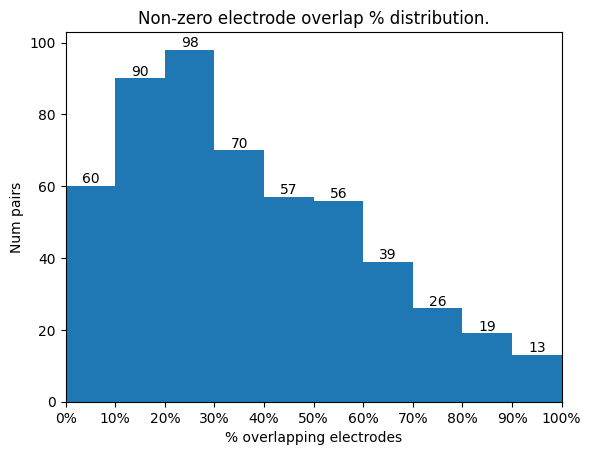

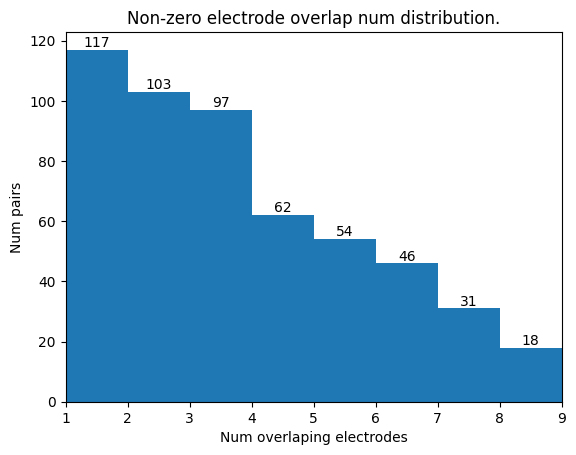

In [32]:
#### ELECTRODE OVERLAP ####
from src import plot

# Graph distribution of electrode overlap scores
nums = []
scores = []
ind_a, ind_b = np.triu_indices(len(propagations), k=1)
for i_a, i_b in zip(ind_a, ind_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]
    num, score = score_elec_overlap(prop_a, prop_b)
    
    if score > 0:
        scores.append(score)
        nums.append(num)
# Create plot
plt.title("Non-zero electrode overlap % distribution.")
plt.xlabel("% overlapping electrodes")
plot.hist(scores, bins=np.arange(0, 101, 10), labels=True)
plt.ylabel("Num pairs")
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10), [f"{r}%" for r in np.arange(0, 101, 10)])
plt.show()

plt.title("Non-zero electrode overlap num distribution.")
plt.xlabel("Num overlaping electrodes")
plot.hist(nums, bins=max(nums)-1, labels=True)
plt.ylabel("Num pairs")
plt.xticks(np.arange(1, max(nums)+1))
plt.xlim(1, max(nums))
plt.show()

In [33]:
ELEC_OVERLAP_N_MIN = 2
ELEC_OVERLAP_P_MIN = 50

Num. propagations: 124


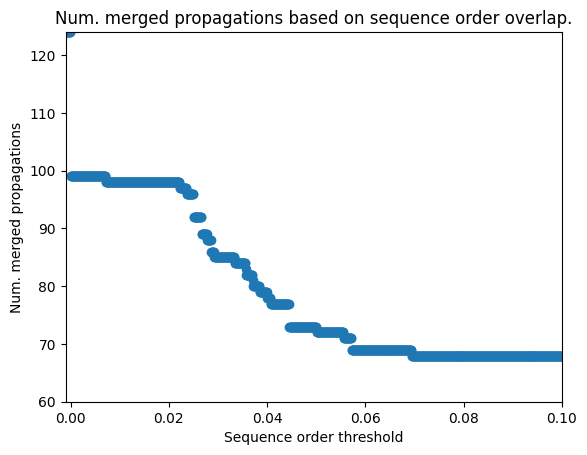

In [34]:
#### SEQUENCE ORDER ####
SEQ_ORDER_EXTREMUM = 100.1  # Value to assign prop pairs that should not be merged
SEQ_ORDER_MAX_VALUES = np.linspace(-0.001, 0.1, num=1000)  # Values to test in plot
##
no_merge_ind_elec = (merge_scores[:, 0] < ELEC_OVERLAP_N_MIN) | (merge_scores[:, 1] < ELEC_OVERLAP_P_MIN)

pdist = merge_scores[:, 2].copy()
pdist[no_merge_ind_elec] = SEQ_ORDER_EXTREMUM

nums_merges = []
means_lens = []
stds_lens = []
for seq_order_max in SEQ_ORDER_MAX_VALUES:
    prop_lens = [len(p) for p in merge(seq_order_max)]
    
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on sequence order overlap.")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_MAX_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_MAX_VALUES), max(SEQ_ORDER_MAX_VALUES))
plt.ylim(60, len(propagations))
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

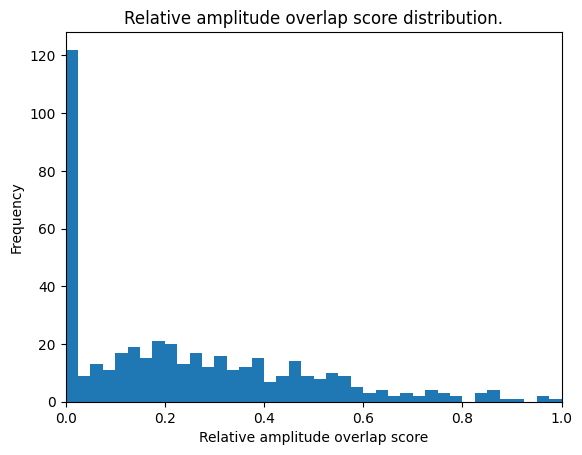

In [35]:
plt.hist(merge_scores[:, 3], range=(0, 1), bins=40)
plt.title("Relative amplitude overlap score distribution.")
plt.xlabel("Relative amplitude overlap score")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

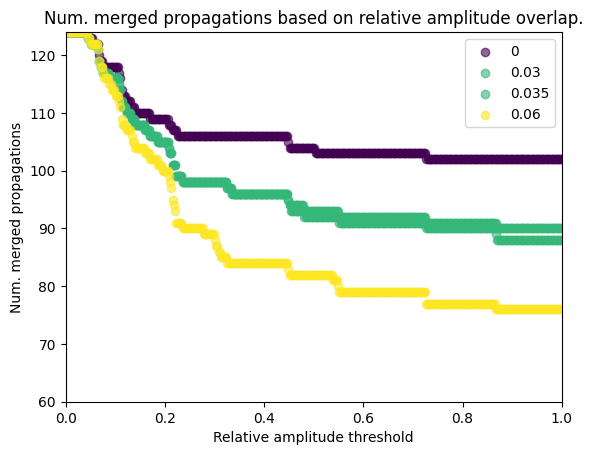

In [36]:
#### RELATIVE AMPLITUDE ####
REL_AMP_EXTREMUM = 1000  # Value to assign prop pairs that should not be merged
REL_AMP_MAX_VALUES = np.linspace(0, 1, num=400)  # Values to test in plot

SEQ_ORDER_MAX_VALUES = [0, 0.03, 0.035, 0.06]
CMAP = plt.cm.get_cmap("viridis", len(SEQ_ORDER_MAX_VALUES))
##
norm = plt.Normalize(SEQ_ORDER_MAX_VALUES[0], SEQ_ORDER_MAX_VALUES[-1])
for seq_order_max in SEQ_ORDER_MAX_VALUES:    
    no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > seq_order_max)

    pdist = merge_scores[:, 3].copy()
    pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

    nums_merges = []
    means_lens = []
    stds_lens = []
    for rel_amp_max in REL_AMP_MAX_VALUES:
        prop_lens = [len(p) for p in merge(rel_amp_max)]
        
        nums_merges.append(len(prop_lens))
        if len(prop_lens) > 0:
            means_lens.append(np.mean(prop_lens))
            stds_lens.append(np.std(prop_lens))
        else:
            means_lens.append(0)
            stds_lens.append(0)
            
    color = CMAP(norm(seq_order_max))
    plt.scatter(REL_AMP_MAX_VALUES, nums_merges, color=color, label=seq_order_max, alpha=0.6)
# print(f"Num. propagations: {len(propagations)}")

# Create plot
plt.title("Num. merged propagations based on relative amplitude overlap.")
plt.xlabel("Relative amplitude threshold")
plt.ylabel("Num. merged propagations")
# plt.scatter(REL_AMP_MAX_VALUES, nums_merges)
plt.xlim(min(REL_AMP_MAX_VALUES), max(REL_AMP_MAX_VALUES))
plt.ylim(60, len(propagations))
plt.legend()
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [37]:
SEQ_ORDER_MAX = 0.03
REL_AMP_MAX = 0.23

Num propagations: 124
Num merged propagations: 99
Mean: 25237.89
STD: 17059.19


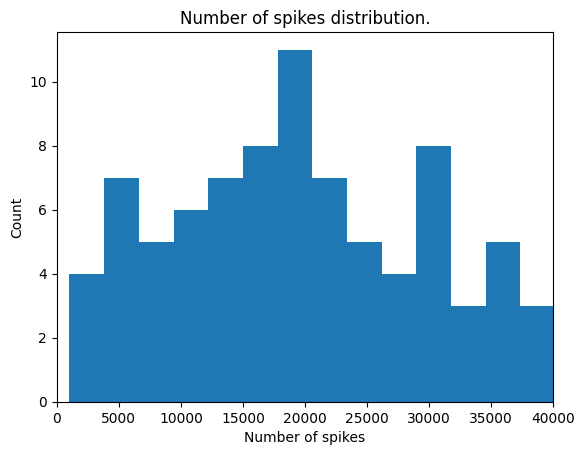

In [42]:
no_merge_ind_seq = no_merge_ind_elec | (merge_scores[:, 2] > SEQ_ORDER_MAX)

pdist = merge_scores[:, 3].copy()
pdist[no_merge_ind_seq] = REL_AMP_EXTREMUM

propagations_merged, propagating_times_merged = merge(REL_AMP_MAX, return_times=True)
print(f"Num propagations: {len(propagations)}")
print(f"Num merged propagations: {len(propagations_merged)}")

from src.sorters.prop_signal import PropSignal
prop_signal = PropSignal((propagations_merged, propagating_times_merged), RECORDING)
prop_signal.plot_nums_spikes(show=False, bins=30)
plt.xlim(0, 40000)
plt.show()

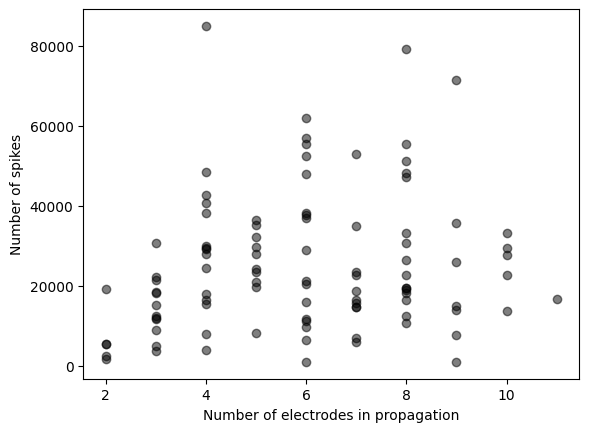

In [53]:
for idx in range(len(prop_signal)):
    prop = prop_signal[idx]
    plt.scatter(len(prop.chans), len(prop), color="black", alpha=0.5)
plt.xlabel("Number of electrodes in propagation")
plt.ylabel("Number of spikes")
plt.show()

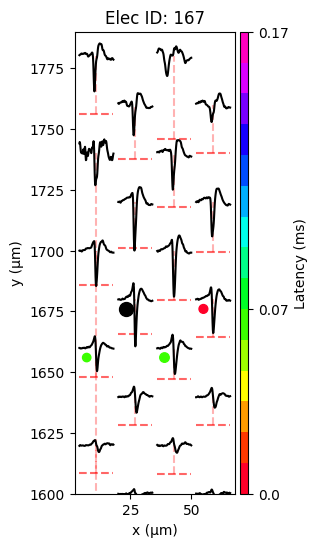

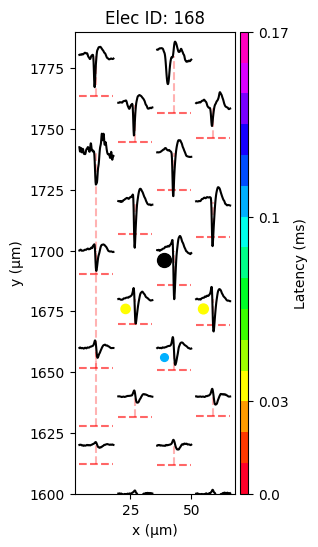

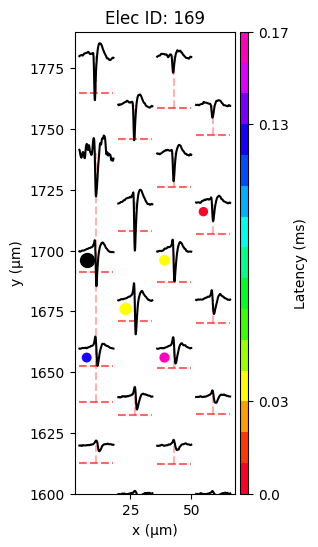

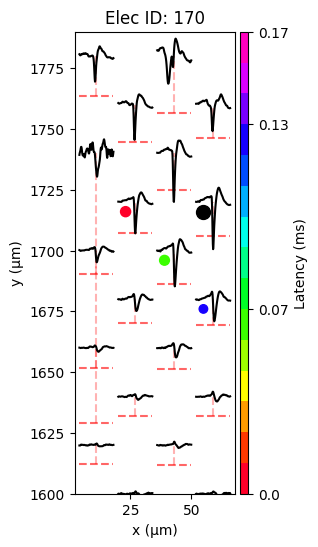

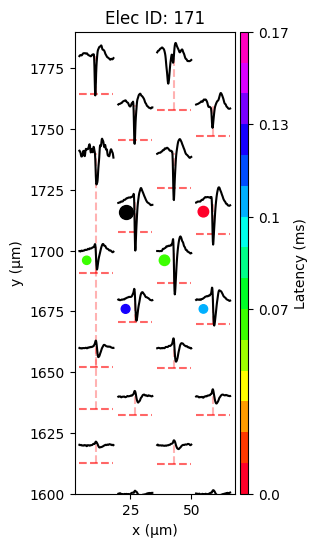

In [67]:
for i in [50, 51, 52, 53, 54]:
    prop_signal[i].plot(chans_rms=CHANS_RMS, vmax=5/30, ylim=(1600, 1790))

## Examine spike splittng problem

In [ ]:
def df_to_prop_idx(df):
    # pandas dataframe to idx in variable "propagations"
    for idx in range(len(propagations)):
        prop = propagations[idx]
        if len(df.ID) == len(prop.ID) and np.all(df.ID == prop.ID):
            return idx
    return None

In [68]:
xlen(kilosort)

340

In [ ]:
# prop_signal = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230717", recording)

In [44]:
spike_train_sets = []
spike_trains = prop_signal.get_spike_times()
for train in spike_trains:
    spike_train_sets.append(set(train))

In [45]:
overlap_ratios = []  # ith value = #not_unique/#total for spikes of ith propagation
overlap_matrix = np.zeros((len(prop_signal), len(prop_signal)), dtype=float)  # [i, j] = num overlaps between units i and j / num spikes i
for i in tqdm(range(len(prop_signal))):
    unique = spike_train_sets[i]
    for j in range(len(prop_signal)):
        if i == j:
            continue
        overlap_matrix[i, j] = len(spike_train_sets[i].intersection(spike_train_sets[j])) / len(spike_train_sets[i])
        unique = unique.difference(spike_train_sets[j])
    overlap_ratios.append(
        (len(spike_train_sets[i]) - len(unique)) / (len(spike_train_sets[i]))
    )        
    

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:12<00:00,  7.69it/s]


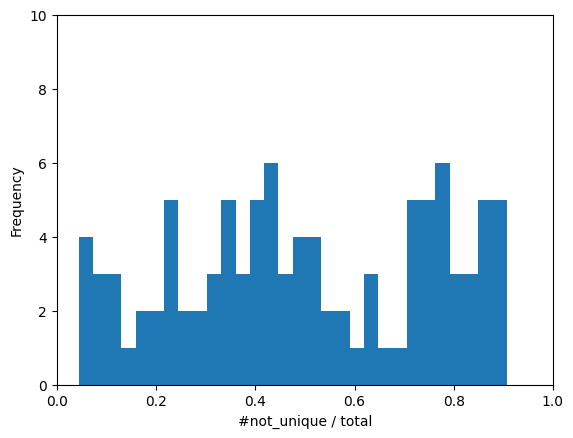

In [52]:
plt.hist(overlap_ratios, bins=30)
plt.yticks(range(0, 12, 2))

plt.ylabel("Frequency")
plt.xlabel("#not_unique / total")
plt.xlim(0, 1)
plt.show()

## Compare with kilosort

In [ ]:
for idx in range(len(kilosort)):
    print("idx", kilosort[idx].chan)

In [ ]:
CHANS = [0, 1, 2, 3]
N_SPIKES = 30
np.random.seed(231)

idx = 0
ks = kilosort[2]

total_offset = np.zeros(4)
for st_idx in tqdm(np.random.choice(len(ks), N_SPIKES)):
    wfs = ks.get_waveforms(spike_time_idx=st_idx, ms_before=60/SAMP_FREQ, ms_after=60/SAMP_FREQ)
    wfs = wfs[CHANS, :]
    peaks = np.argmin(wfs, axis=1)    
    offset = peaks - peaks[ks.chan]
    total_offset += offset
    
    for wf in wfs:
        plot_wf(wf, alpha=0.6)
    plt.show()
    

(4, 121)


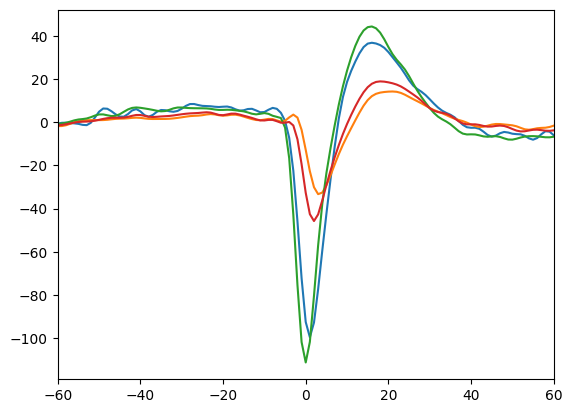

In [207]:
temps = kilosort[2].get_template_mean()[[0, 1, 2, 3]]
print(temps.shape)
for temp in temps:
    plot_wf(temp)
plt.show()

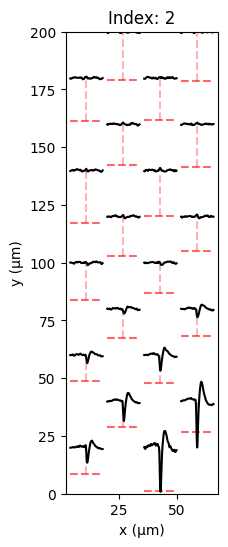

In [215]:
kilosort[2].plot(chans_rms=CHANS_RMS)

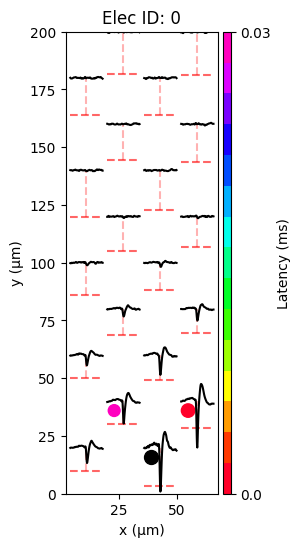

In [214]:
PropUnit(prop, 0, spike_times, RECORDING).plot(chans_rms=CHANS_RMS)

In [ ]:
# """
# Too small
#     0.4, 0.5, 0.55
    
# Too large
#     0.575 0.6 0.9

# """

# propagating_times = np.load(
#     PROP_ROOT / "propagating_times_0.575.npy", 
#     allow_pickle=True
# )

# propagating_times_isi = []
# for prop_times in tqdm(propagating_times):
#     if len(prop_times) == 0:
#         propagating_times_isi.append([0])
#         continue
    
#     last_time = prop_times[0]
#     prop_times_isi = [last_time]
#     for time in prop_times[1:]:
#         if time - last_time > ISI_VIOL:
#             prop_times_isi.append(time)
#             last_time = time
#     propagating_times_isi.append(prop_times_isi)
# propagating_times = propagating_times_isi

# propagations_merged, propagating_times_merged = merge(REL_AMP_MAX, return_times=True)

# prop_signal = PropSignal([propagations_merged, propagating_times_merged], RECORDING)
# prop_signal.plot_nums_spikes(bins=30)

100%|██████████| 124/124 [00:00<00:00, 429.73it/s]


In [47]:
# Num unique spikes
def count_unique_and_total_spikes(sorter):
    spikes_unique = set()
    total = 0
    for spikes in sorter.get_spike_times():
        spikes_unique.update(spikes)
        total += len(spikes)
    
    # return spikes_unique, spikes_total
    unique = len(spikes_unique)
    
    print(f"Unique/Total: {unique}/{total} = {unique/total*100:.1f}%")

# print("Kilosort:")
# count_unique_and_total_spikes(kilosort)
# print()
print("Prop:")
count_unique_and_total_spikes(prop_signal)

Prop:
Unique/Total: 1745470/2498551 = 69.9%


In [49]:
prop_spikes = np.unique(np.concatenate(prop_signal.get_spike_times()))

In [50]:
matches = Comparison.count_matching_events(prop_spikes, kilosort_spikes)
print(matches/len(kilosort_spikes))
print(matches/len(prop_spikes))

0.4976874947495371
0.49554102906380515


Num Prop.: 99
Num Kilosort2: 340
Num single matches: 86

For Prop.:
Num max matches: 90
Num unique max matches: 49

For Kilosort2:
Num max matches: 174
Num unique max matches: 59


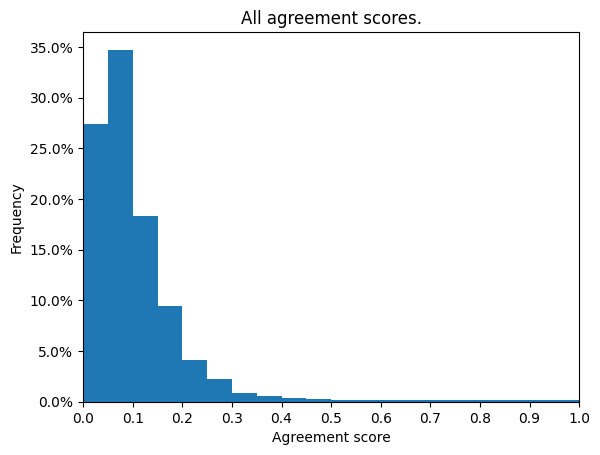

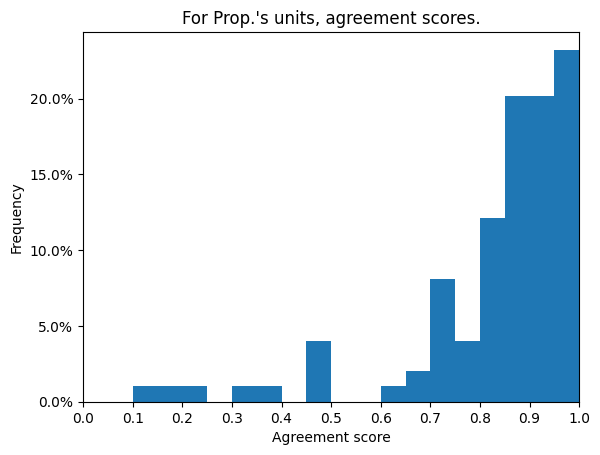

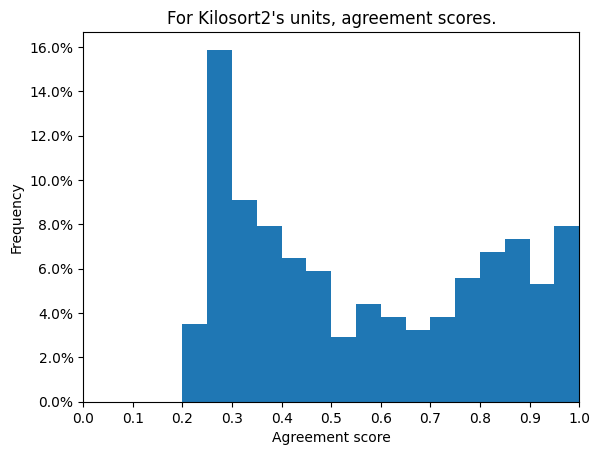

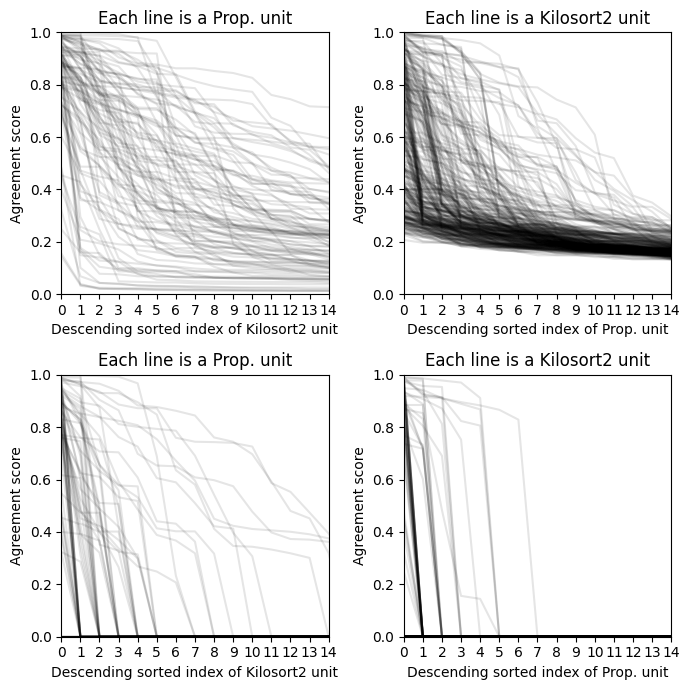

In [51]:
comp = Comparison(prop_signal, kilosort, score_formula=2, delta_time=2)
comp.summary()
comp.plot_line_comps()


In [ ]:
# comp = Comparison(prop_signal, kilosort, score_formula=1, delta_time=1)
# comp.summary()
# comp.plot_line_comps()
